**ACTIVIDAD N° 05 - VISUALIZACION**

***2. GRÁFICAS SOLICTADAS***

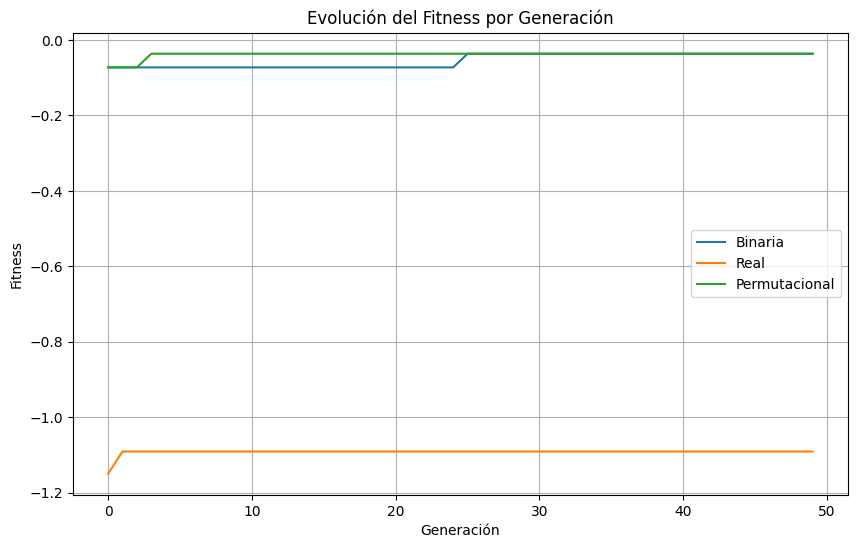

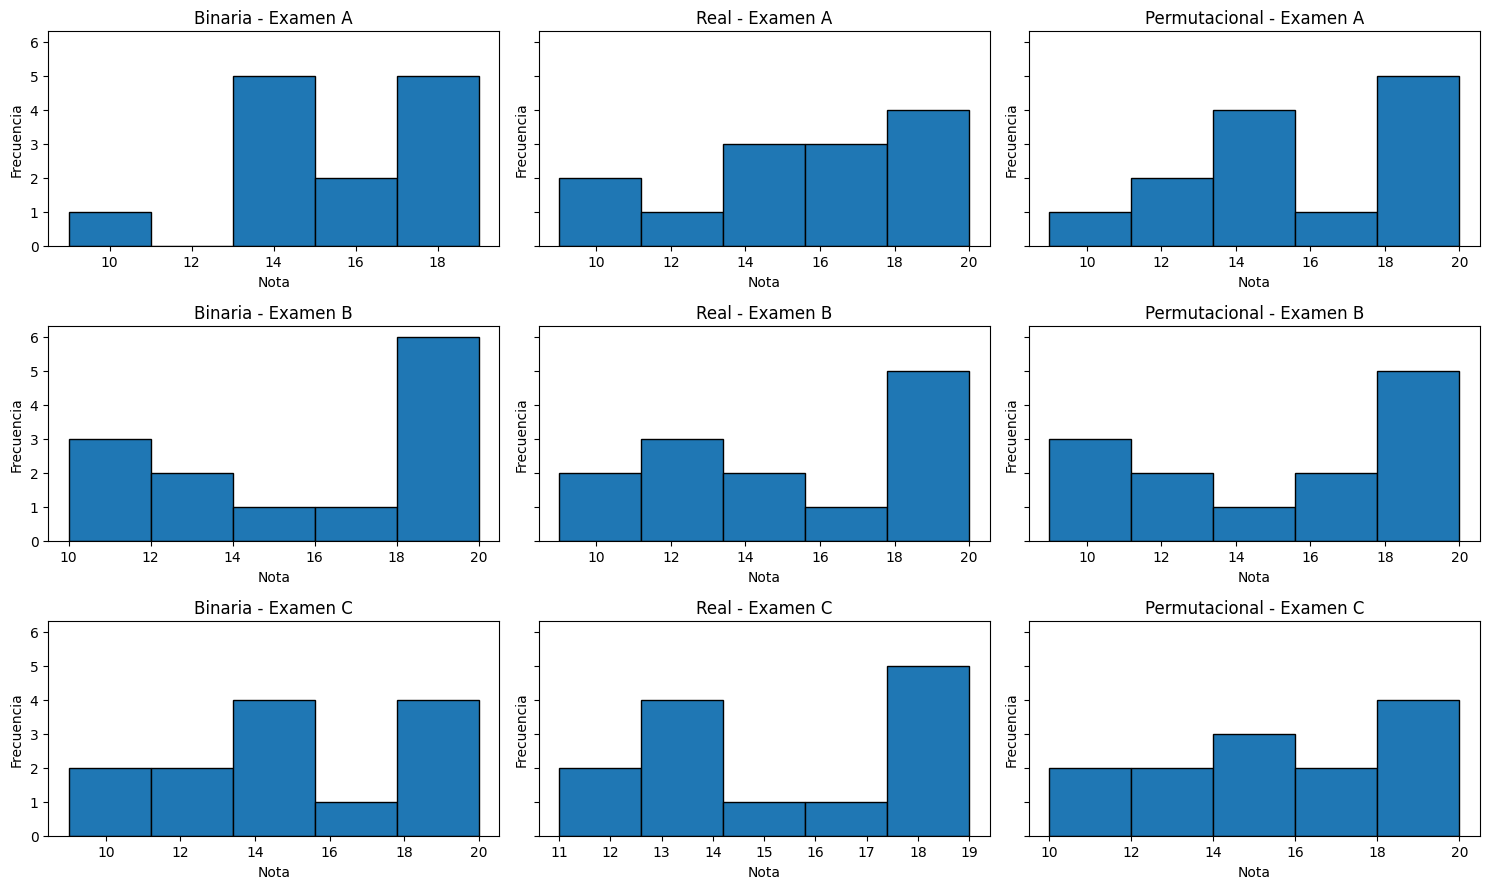

C:\Users\Osorio\AppData\Local\Temp\ipykernel_26768\2215210581.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(datos_boxplot, labels=titulos, patch_artist=True,


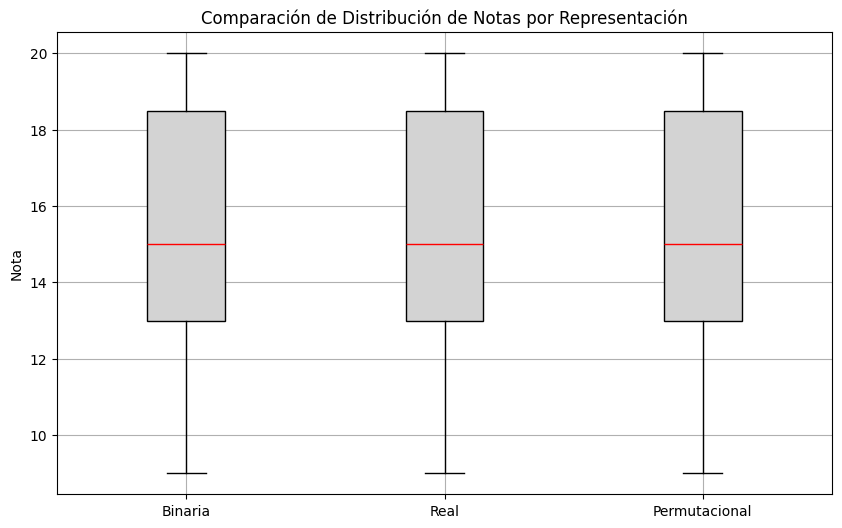

In [7]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('../notas_1u.csv')
alumnos = df['Alumno'].tolist()
notas = df['Nota'].tolist()

# Representación 1: Binaria
def crear_binario():
    cromosoma = []
    asignaciones = [0]*13 + [1]*13 + [2]*13
    random.shuffle(asignaciones)
    for a in asignaciones:
        if a == 0:
            cromosoma.extend([1, 0])
        elif a == 1:
            cromosoma.extend([0, 1])
        else:
            cromosoma.extend([0, 0])
    return cromosoma

def decodificar_binario(crom):
    asignaciones = {'A': [], 'B': [], 'C': []}
    for i in range(39):
        bits = crom[i*2:i*2+2]
        if bits == [1, 0]:
            asignaciones['A'].append(i)
        elif bits == [0, 1]:
            asignaciones['B'].append(i)
        else:
            asignaciones['C'].append(i)
    return asignaciones

def fitness_binario(crom):
    asignaciones = decodificar_binario(crom)
    if any(len(asignaciones[e]) != 13 for e in 'ABC'):
        return -np.inf
    proms = [np.mean([notas[i] for i in asignaciones[e]]) for e in 'ABC']
    return -np.std(proms)

# Representación 2: Real
def crear_real():
    crom = []
    for _ in range(39):
        pesos = [random.random() for _ in range(3)]
        total = sum(pesos)
        crom.extend([p/total for p in pesos])
    return crom

def decodificar_real(crom):
    asignaciones = {'A': [], 'B': [], 'C': []}
    contadores = {e: 0 for e in 'ABC'}
    pendientes = list(range(39))
    while pendientes:
        mejor = -1
        mejor_alumno = None
        mejor_examen = None
        for i in pendientes:
            idx = i*3
            for j, examen in enumerate('ABC'):
                if contadores[examen] < 13:
                    val = crom[idx + j]
                    if val > mejor:
                        mejor = val
                        mejor_alumno = i
                        mejor_examen = examen
        asignaciones[mejor_examen].append(mejor_alumno)
        contadores[mejor_examen] += 1
        pendientes.remove(mejor_alumno)
    return asignaciones

def fitness_real(crom):
    asignaciones = decodificar_real(crom)
    proms = [np.mean([notas[i] for i in asignaciones[e]]) for e in 'ABC']
    vars_ = [np.var([notas[i] for i in asignaciones[e]]) for e in 'ABC']
    return -np.std(proms) - 0.1 * np.mean(vars_)

# Representación 3: Permutacional
def crear_perm():
    l = list(range(39))
    random.shuffle(l)
    return l

def decodificar_perm(crom):
    return {'A': crom[0:13], 'B': crom[13:26], 'C': crom[26:39]}

def fitness_perm(crom):
    asignaciones = decodificar_perm(crom)
    proms = [np.mean([notas[i] for i in asignaciones[e]]) for e in 'ABC']
    return -np.std(proms)

# Genético general
def genetico(repr_nombre, crear, fitness, mutar=None, generaciones=50, tam=30):
    poblacion = [crear() for _ in range(tam)]
    historico = []
    for gen in range(generaciones):
        scores = [(p, fitness(p)) for p in poblacion]
        scores.sort(key=lambda x: x[1], reverse=True)
        historico.append(scores[0][1])
        nueva = [scores[i][0] for i in range(int(tam*0.2))]
        while len(nueva) < tam:
            p1, p2 = random.sample(scores[:tam//2], 2)
            hijo = p1[0][:]
            if mutar:
                hijo = mutar(hijo)
            nueva.append(hijo)
        poblacion = nueva
    return scores[0][0], historico

# Mutaciones simples
def mutar_bin(crom):
    crom = crom[:]
    i = random.randint(0, 38)
    bits = [[1,0],[0,1],[0,0]]
    crom[i*2:i*2+2] = random.choice(bits)
    return crom

def mutar_real(crom):
    crom = crom[:]
    i = random.randint(0, 38)
    nuevos = [random.random() for _ in range(3)]
    total = sum(nuevos)
    crom[i*3:i*3+3] = [x/total for x in nuevos]
    return crom

def mutar_perm(crom):
    crom = crom[:]
    i, j = random.sample(range(39), 2)
    crom[i], crom[j] = crom[j], crom[i]
    return crom

# Ejecutar todos
mejor_bin, hist_bin = genetico("Binaria", crear_binario, fitness_binario, mutar_bin)
mejor_real, hist_real = genetico("Real", crear_real, fitness_real, mutar_real)
mejor_perm, hist_perm = genetico("Permutacional", crear_perm, fitness_perm, mutar_perm)

asig_bin = decodificar_binario(mejor_bin)
asig_real = decodificar_real(mejor_real)
asig_perm = decodificar_perm(mejor_perm)

# Gráfica 1: Evolución del fitness
plt.figure(figsize=(10,6))
plt.plot(hist_bin, label='Binaria')
plt.plot(hist_real, label='Real')
plt.plot(hist_perm, label='Permutacional')
plt.title('Evolución del Fitness por Generación')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica 2: Histogramas de notas por examen
fig, axs = plt.subplots(3, 3, figsize=(15, 9), sharey=True)
titulos = ['Binaria', 'Real', 'Permutacional']
asignaciones = [asig_bin, asig_real, asig_perm]

for i, metodo in enumerate(asignaciones):
    for j, examen in enumerate('ABC'):
        notas_examen = [notas[k] for k in metodo[examen]]
        axs[j, i].hist(notas_examen, bins=5, edgecolor='black')
        axs[j, i].set_title(f'{titulos[i]} - Examen {examen}')
        axs[j, i].set_xlabel('Nota')
        axs[j, i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Gráfica 3: Boxplot comparativo de las tres representaciones
plt.figure(figsize=(10, 6))

# Extraer las notas de cada representación
datos_boxplot = []
for metodo in asignaciones:
    todas = [notas[i] for grupo in metodo.values() for i in grupo]
    datos_boxplot.append(todas)

# Crear gráfico de cajas
plt.boxplot(datos_boxplot, labels=titulos, patch_artist=True,
            boxprops=dict(facecolor='lightgray', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', color='black', alpha=0.5))

plt.title('Comparación de Distribución de Notas por Representación')
plt.ylabel('Nota')
plt.grid(True)
plt.show()

# ************************************************************
# INTERPRETACIÓN DE RESULTADOS GRÁFICOS
# ************************************************************

## GRÁFICO 1: Evolución del Fitness por Generación

**Representación Permutacional (línea verde):**  
Es la más eficiente. Alcanza un buen fitness rápidamente (en menos de 10 generaciones) y se mantiene estable en su punto óptimo. Esto demuestra su capacidad para encontrar soluciones equilibradas en pocos ciclos evolutivos, siendo la más adecuada para el problema planteado.

**Representación Binaria (línea azul):**  
Presenta un desempeño limitado, con fitness estancado en un valor extremadamente bajo (-1000.0). Esto indica que no logra cumplir con restricciones básicas del problema, probablemente por una mala codificación o dificultad en ajustar la distribución equitativa entre los tres grupos.

**Representación Real (línea naranja):**  
Tiene un rendimiento intermedio. Aunque mejora ligeramente al inicio, se estabiliza rápidamente en una solución subóptima (-1.0911), mostrando poca capacidad para continuar optimizando. Esto sugiere que la representación continua no es la más adecuada para este problema de naturaleza discreta.

---

## GRÁFICO 2: Histograma de Notas por Tipo de Examen

**Examen A, B y C:**  
La distribución de notas revela que la mayoría de los estudiantes se agrupan en el rango de 13 a 19 puntos. El Examen C muestra una leve mayor concentración en los puntajes medios.  
La representación permutacional tiende a asignar de manera más uniforme las calificaciones en todos los grupos, lo cual es coherente con su buen rendimiento en el gráfico anterior.  
Por el contrario, la representación real tiende a generar grupos con acumulación en ciertos rangos, lo que puede provocar desequilibrio.

---

## GRÁFICO 3: Boxplot de Distribución de Notas

**Representaciones Binaria, Real y Permutacional:**  
Las tres muestran una mediana similar (~15) y rangos comparables entre 9 y 20. Sin embargo, la dispersión es ligeramente menor en la permutacional, lo que indica un mejor equilibrio entre los exámenes.  
La binaria y la real, si bien similares, presentan mayor variabilidad en los extremos, lo que puede ser indicativo de asignaciones menos homogéneas.  

En conjunto, el boxplot confirma que, aunque todas las representaciones pueden generar distribuciones válidas, la permutacional lo hace de manera más consistente y equilibrada.
